## Import Data and libraries

Import all librarys we need during the notebook

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
import scipy
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.utils import load_img, img_to_array
from keras.models import load_model
from keras.optimizers import Adam, SGD

#### Load the data of the directory

In [2]:
data_dir = "./data/Train/"

Split the data in 2 dataset: 1 for train and another for validation.

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 3256 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 814 files for validation.


In [8]:
class_names = train_ds.class_names
print(f'This is the list of the names of all classes {class_names}')

This is the list of the names of all classes ['Bathroom', 'Bedroom', 'House Map', 'Kitchen', 'Living Room']


#### Dataset exploration

Show a sample of the 9 first images with their own labels

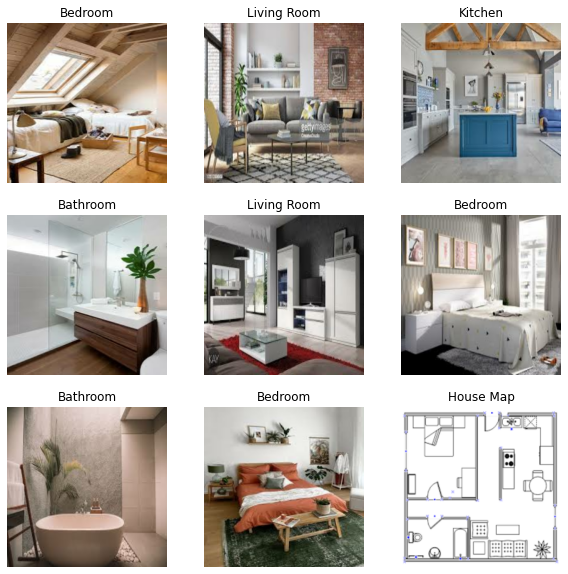

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We see that the each batch have 32 images and each image have the dimensions of (256,256,3) where 3 mean the RGB of each pixel

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Lets show how much images we have in the training for class

# Preprocess data

Scale the image dividing it by 255

In [10]:
normalization_layer = Rescaling(1./255)

In [15]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_valid_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
#Print the min and max to check if is right normalized [0,1] 
print(np.min(first_image),np.max(first_image))

0.0 1.0


# Train the models

## Model trained using convultional neural network

First we create a convultional neural network with all layers we find 

In [39]:
numberOfClass = len(class_names)
def def_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape = input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(32,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(64,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(numberOfClass)) # output
    model.add(Activation("softmax"))
    return model

In [22]:
conv_model = def_conv_model(input_shape=(256,256,3))

In [23]:
conv_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [25]:
epochs=20
conv_hist = conv_model.fit(
  normalized_train_ds,
  validation_data= normalized_valid_ds,
  epochs=epochs
)

Epoch 1/20


c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


102/102 [==============================] - 139s 1s/step - loss: 1.5722 - accuracy: 0.3326 - val_loss: 1.3547 - val_accuracy: 0.3747
Epoch 2/20
102/102 [==============================] - 152s 1s/step - loss: 1.2393 - accuracy: 0.4665 - val_loss: 1.1875 - val_accuracy: 0.5049
Epoch 3/20
102/102 [==============================] - 133s 1s/step - loss: 0.9719 - accuracy: 0.6038 - val_loss: 1.1495 - val_accuracy: 0.5455
Epoch 4/20
102/102 [==============================] - 135s 1s/step - loss: 0.7241 - accuracy: 0.7199 - val_loss: 1.2802 - val_accuracy: 0.5553
Epoch 5/20
102/102 [==============================] - 127s 1s/step - loss: 0.4450 - accuracy: 0.8345 - val_loss: 1.3301 - val_accuracy: 0.5921
Epoch 6/20
102/102 [==============================] - 125s 1s/step - loss: 0.2401 - accuracy: 0.9186 - val_loss: 1.6218 - val_accuracy: 0.5762
Epoch 7/20
102/102 [==============================] - 127s 1s/step - loss: 0.1722 - accuracy: 0.9475 - val_loss: 1.9165 - val_accuracy: 0.5774
Epoch 8/20

In [49]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [50]:
plot_history(conv_hist)

NameError: name 'conv_hist' is not defined

## Model with convolutional neural network using image data generator

In [42]:
width_shape = 224
height_shape = 224
num_classes = len(class_names)
epochs = 50
batch_size = 32 

We are going to apply the Image Data Generator keras function to modify the images of the training dataset applying some random zoom , some shear and a random horizontal flip because the photographs uploaded by the user will be usual people not professional photographer.
In the validation dataset we only rescale as we did before.

In [52]:

train_datagen = ImageDataGenerator( 
    rescale= 1./255,
    zoom_range=0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    validation_split= 0.2)
    # width_shift_range=0.2,
    # height_shift_range=0.2,

valid_datagen = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "training",
    batch_size= batch_size)

valid_generator = valid_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "validation",
    batch_size= batch_size)


Found 3258 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


We print all classes and the first value to verify is correct

In [44]:

print(train_generator.class_indices)
print(train_generator.next()[0][1])

{'Bathroom': 0, 'Bedroom': 1, 'House Map': 2, 'Kitchen': 3, 'Living Room': 4}
[[[0.5911731  0.58725154 0.5715653 ]
  [0.18532614 0.18140458 0.1657183 ]
  [0.20423311 0.20031154 0.18571146]
  ...
  [0.90852964 0.9046081  0.8889218 ]
  [0.90943915 0.9055176  0.8898313 ]
  [0.890698   0.88677645 0.8710902 ]]

 [[0.69205904 0.6881375  0.6724512 ]
  [0.18528369 0.18136212 0.16567585]
  [0.20152879 0.19760722 0.18300244]
  ...
  [0.9146338  0.91071224 0.89502597]
  [0.91721    0.9132884  0.89760214]
  [0.90345114 0.8995296  0.8838433 ]]

 [[0.69449896 0.6905774  0.6748911 ]
  [0.16831173 0.16439016 0.14870387]
  [0.20404829 0.20012672 0.18551725]
  ...
  [0.89057255 0.886651   0.8709647 ]
  [0.8829083  0.8789867  0.86330044]
  [0.90853536 0.9046138  0.8889275 ]]

 ...

 [[0.74974966 0.62814516 0.45570382]
  [0.6752982  0.5540926  0.38174802]
  [0.6984316  0.59277695 0.42407358]
  ...
  [0.77934635 0.7244444  0.7126797 ]
  [0.7837977  0.7288957  0.717131  ]
  [0.7811275  0.72622555 0.71446085

Plot examples of the images with data image generator

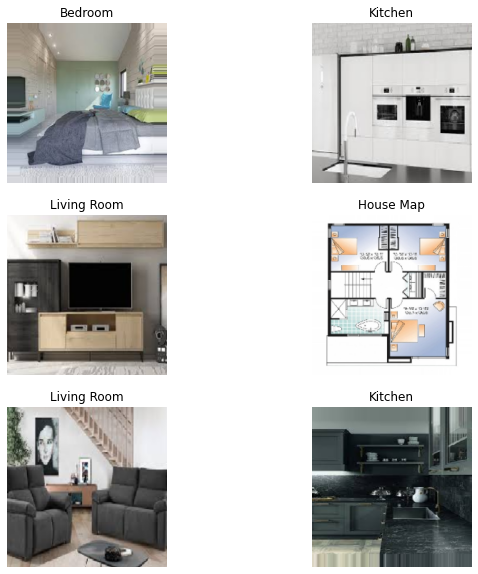

In [45]:
batch =  train_generator.next()
  
plt.figure(figsize=(10, 10))

for i in range(6):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(batch[0][i])
  plt.title(class_names[np.argmax(batch[1][i])])
  plt.axis("off")

In [46]:
model_conv_with_data_gen = def_conv_model(input_shape=(224,224,3))

In [47]:
model_conv_with_data_gen.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

conv_hist_with_data_generator = model_conv_with_data_gen.fit(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

Epoch 1/50
 69/102 [===================>..........] - ETA: 31s - loss: 1.8862 - accuracy: 0.2816

c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


102/102 [==============================] - 101s 985ms/step - loss: 1.7360 - accuracy: 0.3103 - val_loss: 1.3149 - val_accuracy: 0.4618
Epoch 2/50
102/102 [==============================] - 117s 1s/step - loss: 1.2843 - accuracy: 0.4472 - val_loss: 1.1924 - val_accuracy: 0.5135
Epoch 3/50
102/102 [==============================] - 115s 1s/step - loss: 1.1174 - accuracy: 0.5424 - val_loss: 1.2234 - val_accuracy: 0.4963
Epoch 4/50
102/102 [==============================] - 113s 1s/step - loss: 1.0446 - accuracy: 0.5681 - val_loss: 1.0910 - val_accuracy: 0.5456
Epoch 5/50
102/102 [==============================] - 113s 1s/step - loss: 1.0077 - accuracy: 0.5816 - val_loss: 1.0848 - val_accuracy: 0.5603
Epoch 6/50
102/102 [==============================] - 112s 1s/step - loss: 0.9252 - accuracy: 0.6255 - val_loss: 1.0702 - val_accuracy: 0.5579
Epoch 7/50
102/102 [==============================] - 113s 1s/step - loss: 0.9016 - accuracy: 0.6338 - val_loss: 1.0837 - val_accuracy: 0.5468
Epoch 8

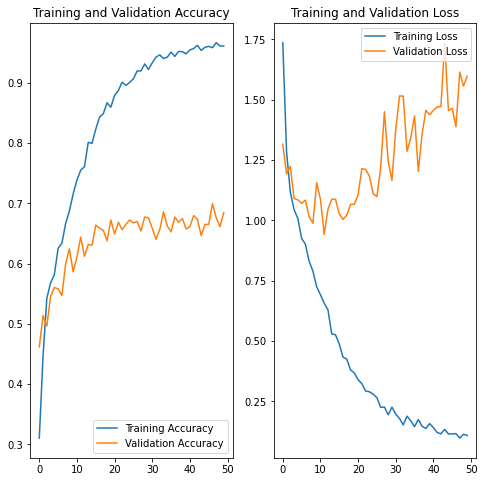

In [51]:
plot_history(conv_hist_with_data_generator)

### Model using transfer learning techniche with MobileNetV2 layers

In [8]:
numberOfClass = len(class_names)

NameError: name 'class_names' is not defined

In [36]:
base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dropout(0.5)(x)
preds=Dense(numberOfClass,activation='softmax')(x) #final layer with softmax activation

In [37]:
transfer_learning_model=Model(inputs=base_model.input,outputs=preds)

In [38]:
for i,layer in enumerate(transfer_learning_model.layers):
  print(i,layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [39]:
for layer in transfer_learning_model.layers[:-6]:
    layer.trainable=False

In [40]:
transfer_learning_model.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

transfer_learning_hist = transfer_learning_model.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_18968\689159174.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_hist = transfer_learning_model.fit_generator(train_generator,


Epoch 1/50
102/102 [==============================] - 97s 931ms/step - loss: 0.6899 - accuracy: 0.7449 - val_loss: 0.4438 - val_accuracy: 0.8313
Epoch 2/50
102/102 [==============================] - 92s 902ms/step - loss: 0.4146 - accuracy: 0.8511 - val_loss: 0.3812 - val_accuracy: 0.8534
Epoch 3/50
102/102 [==============================] - 91s 892ms/step - loss: 0.4146 - accuracy: 0.8496 - val_loss: 0.3924 - val_accuracy: 0.8534
Epoch 4/50
102/102 [==============================] - 90s 878ms/step - loss: 0.3818 - accuracy: 0.8656 - val_loss: 0.3523 - val_accuracy: 0.8547
Epoch 5/50
102/102 [==============================] - 86s 842ms/step - loss: 0.3629 - accuracy: 0.8705 - val_loss: 0.3615 - val_accuracy: 0.8805
Epoch 6/50
102/102 [==============================] - 85s 832ms/step - loss: 0.3261 - accuracy: 0.8785 - val_loss: 0.2981 - val_accuracy: 0.8879
Epoch 7/50
102/102 [==============================] - 93s 912ms/step - loss: 0.3245 - accuracy: 0.8791 - val_loss: 0.3456 - val_ac

KeyboardInterrupt: 

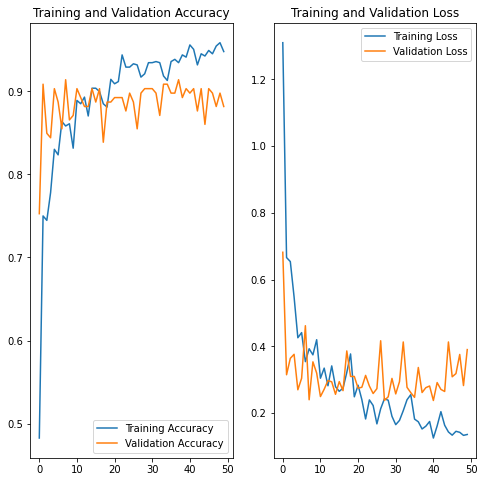

In [ ]:
plot_history(transfer_learning_hist)

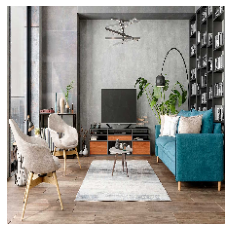

NameError: name 'transfer_learning_model' is not defined

In [9]:
def load_image(img_path, show=False):


    img = load_img(img_path, target_size=(width_shape, height_shape))
    img_tensor =    img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.  
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\salon1.jpeg'
new_image = load_image(img_path,show=True)

pred = transfer_learning_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


In [ ]:
transfer_learning_model.save("./Models/model_transfer_learning/model_transfer_learning.h5",overwrite=True)

In [74]:
transfer_learning_model = load_model('Models\model_transfer_learning\model_transfer_learning.h5')

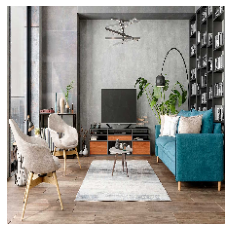

1/1 [==============================] - 1s 655ms/step


array([[3.9193814e-04, 4.2227149e-02, 3.7691669e-07, 5.3831653e-05,
        9.5732671e-01]], dtype=float32)

In [75]:
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\salon1.jpeg'
new_image = load_image(img_path,show=True)

pred = transfer_learning_model.predict(new_image)

pred

Model unfreezing the first layers of the previous model and learning with a little learning rate

In [76]:
transfer_learning_modelv2 = tf.keras.models.clone_model(transfer_learning_model)

In [77]:
# for layer in transfer_learning_modelv2.layers[60:]:
#     layer.trainable = True
# for layer in transfer_learning_modelv2.layers[:60]:
#     layer.trainable = False

In [78]:
transfer_learning_modelv2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [79]:
print(len(transfer_learning_modelv2.trainable_variables))
print(len(transfer_learning_modelv2.layers))

8
160


In [80]:
transfer_learning_modelv2.compile(optimizer = SGD(lr=0.0001, momentum=0.9), loss = categorical_crossentropy, metrics = ['accuracy'] )
epochs = 10

transfer_learning_hist_v2 = transfer_learning_modelv2.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_6808\3001217616.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_hist_v2 = transfer_learning_modelv2.fit_generator(train_generator,


Epoch 1/10
102/102 [==============================] - 83s 788ms/step - loss: 1.6078 - accuracy: 0.2907 - val_loss: 1.6057 - val_accuracy: 0.2931
Epoch 2/10
102/102 [==============================] - 80s 781ms/step - loss: 1.6038 - accuracy: 0.2922 - val_loss: 1.6018 - val_accuracy: 0.2931
Epoch 3/10
102/102 [==============================] - 78s 767ms/step - loss: 1.5999 - accuracy: 0.2922 - val_loss: 1.5981 - val_accuracy: 0.2931
Epoch 4/10
102/102 [==============================] - 57749s 572s/step - loss: 1.5964 - accuracy: 0.2922 - val_loss: 1.5947 - val_accuracy: 0.2931
Epoch 5/10
102/102 [==============================] - 96s 933ms/step - loss: 1.5933 - accuracy: 0.2922 - val_loss: 1.5916 - val_accuracy: 0.2931
Epoch 6/10
102/102 [==============================] - 98s 960ms/step - loss: 1.5904 - accuracy: 0.2922 - val_loss: 1.5889 - val_accuracy: 0.2931
Epoch 7/10
102/102 [==============================] - 96s 946ms/step - loss: 1.5875 - accuracy: 0.2922 - val_loss: 1.5862 - val_

In [81]:
plot_history(transfer_learning_hist_v2)

64377.18s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 239, in _set
    _check_l